## Import Libraries

In [1]:
from unityagents import UnityEnvironment
from sac import Agent
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import torch

## Importing the required libraries

In [2]:
path = "./Reacher_Windows_x86_64/Reacher.exe"
env = UnityEnvironment(file_name=path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Set the brain of the environment

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [5]:
# spectrum of each action lies between -1 and 1. dimension of action space is 4
action_low = np.array([-1, -1, -1, -1])
action_high = np.array([1, 1, 1, 1])

## Initialize the agent

In [6]:
# set up the agent
agent = Agent(state_size=state_size, action_size=action_size, action_low=action_low, action_high=action_high)

## Train the agent

In [7]:
def model(n_episodes=2000):

    scores_deque = deque(maxlen=100)
    scores = []
    avg_scores = []

    for i_episode in range(1, n_episodes+1):

        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations[0]          # get the current state
        score = 0

        while True:
            actions = agent.act(states)                   # select an action
            actions = agent.action_adapter(actions)       # adapt the action to the environment

            env_info = env.step(actions)[brain_name]         # send the action to the environment
            next_states = env_info.vector_observations[0]    # get the next state
            rewards = env_info.rewards[0]                    # get the reward
            dones = env_info.local_done[0]                   # see if episode has finished


            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if np.any(dones):                             # exit loop if episode finished
                break

        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")

        if i_episode % 100 == 0:
            avg_scores.append(np.mean(scores_deque))
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            break

    
    # calculate the average score over the last 100 episodes
    running_mean = []
    for i in range(len(scores)):
        if i < 100:
            running_mean.append(np.mean(scores[:i+1]))
        else:
            running_mean.append(np.mean(scores[i-100:i+1]))
    

    # plot the scores
    fig = plt.figure(figsize=(10, 5))
    plt.plot(np.arange(len(scores)), scores, label="Score")
    plt.plot(np.arange(len(running_mean)), running_mean, label="Running Mean")
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.legend(loc='upper left')
    plt.show()

    # save the model
    torch.save(agent.actor.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_1.state_dict(), 'checkpoint_critic_1.pth')
    torch.save(agent.critic_2.state_dict(), 'checkpoint_critic_2.pth')


    return scores

Episode 100	Average Score: 5.21
Episode 200	Average Score: 13.05
Episode 300	Average Score: 19.19
Episode 400	Average Score: 24.12
Episode 500	Average Score: 29.65
Episode 507	Average Score: 30.07
Environment solved in 507 episodes!	Average Score: 30.07


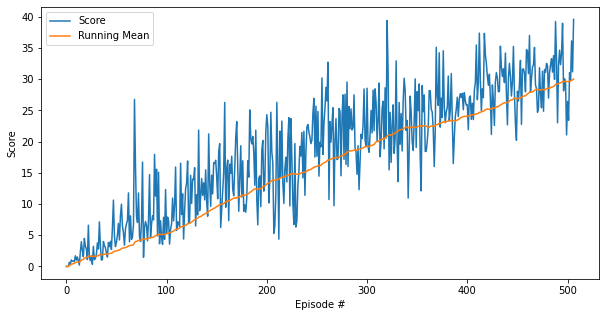

In [8]:
scores = model()

In [9]:
env.close()